In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected=True)

In [3]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [3]:
dataset=pd.read_csv(r'C:\Users\eldiy\Documents\GitHub\My own labs\mlcourse.ai\data/hour_online.csv', parse_dates=['Time'], index_col='Time')
dataset.head()

,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2625 entries, 2017-01-01 00:00:00 to 2017-04-20 09:00:00
Data columns (total 1 columns):
Users    2625 non-null int64
dtypes: int64(1)
memory usage: 41.0 KB


In [10]:
plotly_df(dataset, title='Online users')

In [11]:
def moving_average(series,n):
    return np.average(series[-n:])

moving_average(dataset.Users,24)

29858.333333333332

In [12]:
def plotMovingAverage(series, n, plot_bounds=False):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """
    
    rolling_mean = series.rolling(window=n).mean()
        
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_bounds:
        rolling_std =  series.rolling(window=n).std()
        upper_bound = rolling_mean+1.96*rolling_std
        lower_bound = rolling_mean-1.96*rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'));
    plt.xticks(rotation=45)

C:\Users\eldiy\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



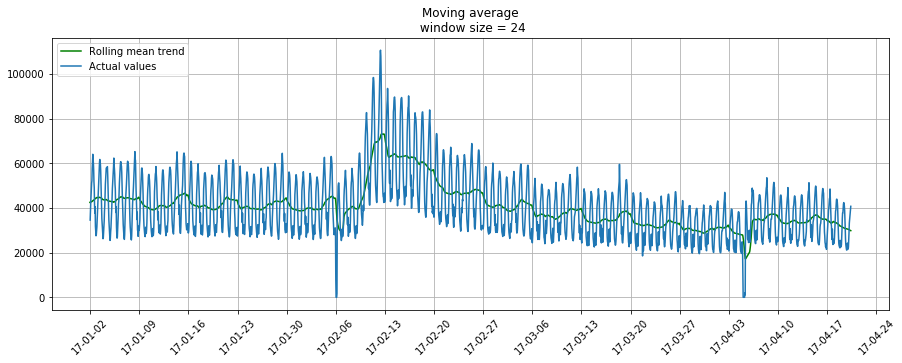

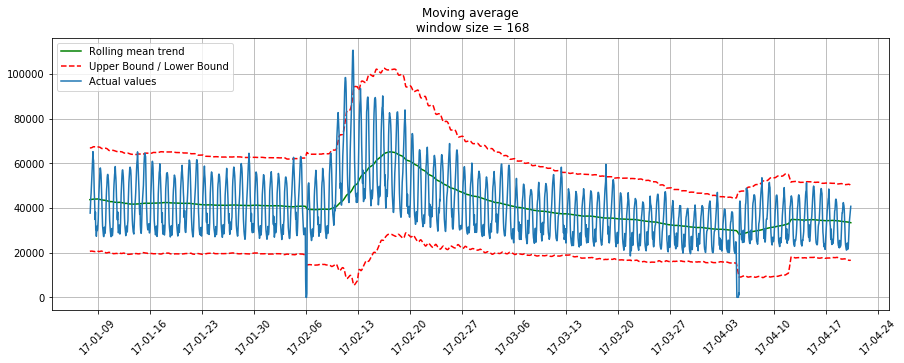

In [13]:
plotMovingAverage(dataset,24)
plotMovingAverage(dataset,24*7, plot_bounds=True)

In [16]:
def weighted_average(series, weights):
    result=0.0
    for n in range(len(weights)):
        result += series[-n-1]*weights[n]
    return result

In [23]:
weighted_average(dataset.Users, [0.6,0.2,0.1,0.07,0.03])

39907.43

In [22]:
weights=[0.6,0.2,0.1,0.07,0.03,0.01]
for n in range(len(weights)):
    print(dataset.Users[-n])

34002
40763
40238
38418
35932
34833


In [24]:
def exponential_smoothing(series, alpha):
    result=[series[0]]
    for n in range(1,len(series)):
        result.append(alpha*series[n]+(1-alpha)*result[n-1])
    return result

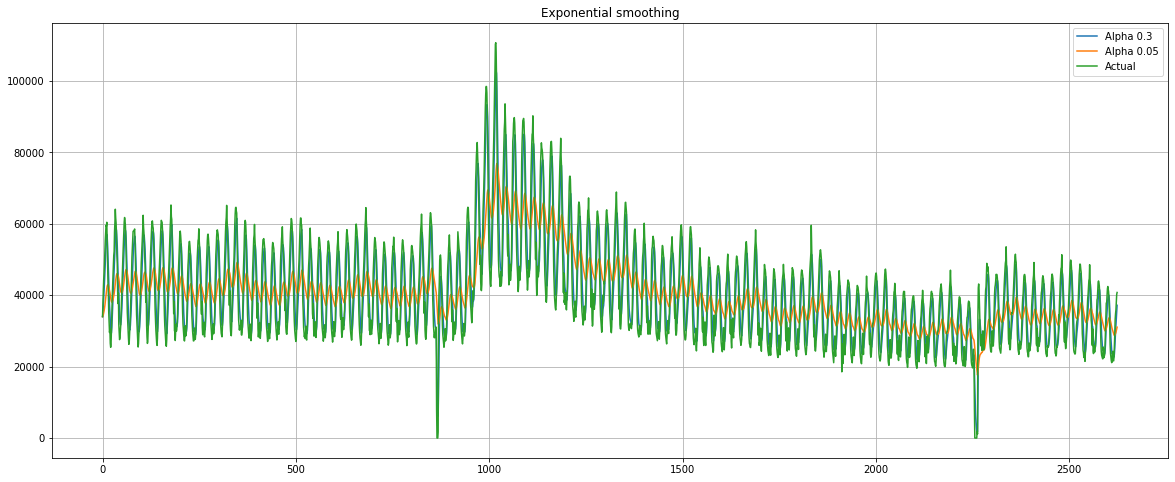

In [28]:
plt.figure(figsize=(20,8))
for alpha in [0.3,0.05]:
    plt.plot(exponential_smoothing(dataset.Users,alpha),label=f'Alpha {alpha}')
plt.plot(dataset.Users.values,label='Actual')
plt.legend(loc='best')
plt.title('Exponential smoothing')
plt.grid(True)
plt.show()

In [30]:
dataset['exponential_smoothing']=exponential_smoothing(dataset.Users,0.3)
plotly_df(dataset, 'Exponential smoothing')

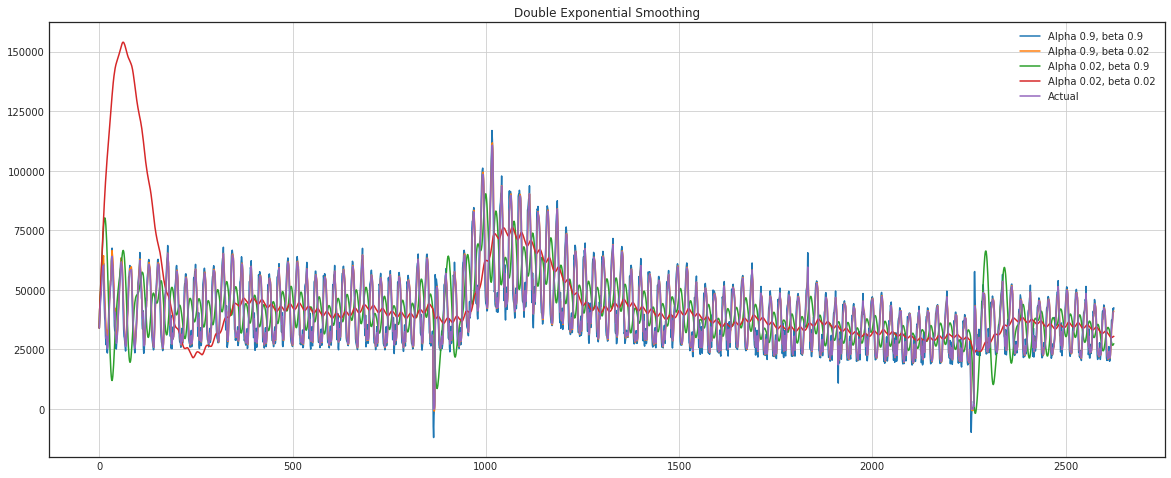

In [31]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [33]:
class HoltWinters:
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        seasonals = self.initial_seasonal_components()
        for i in range(len(self.series)+self.n_preds):
            if i == 0: 
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                self.PredictedDeviation.append(0)
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
            if i >= len(self.series): 
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
        

In [68]:
from sklearn.model_selection import TimeSeriesSplit
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [70]:
from sklearn.metrics import mean_squared_log_error
data=dataset.Users[:500] #last 500 for test

x=[0,0,0] #initial parameters
   
opt=minimize(timeseriesCVscore, x0=x, 
             args=(data,mean_squared_log_error), method='TNC', bounds=((0,1),(0,1),(0,1))) 
#minimize the errors with limitations on the parameters (alpha, beta, gamma) to be within (0,1) range

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final,beta_final,gamma_final)

0.09180319125518865 0.008502005148690261 0.40146312699690334


In [71]:
model=HoltWinters(data, slen=24, alpha=alpha_final, beta=beta_final, gamma=gamma_final,
                 n_preds=50, scaling_factor=3)
model.triple_exponential_smoothing()

In [72]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):

    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

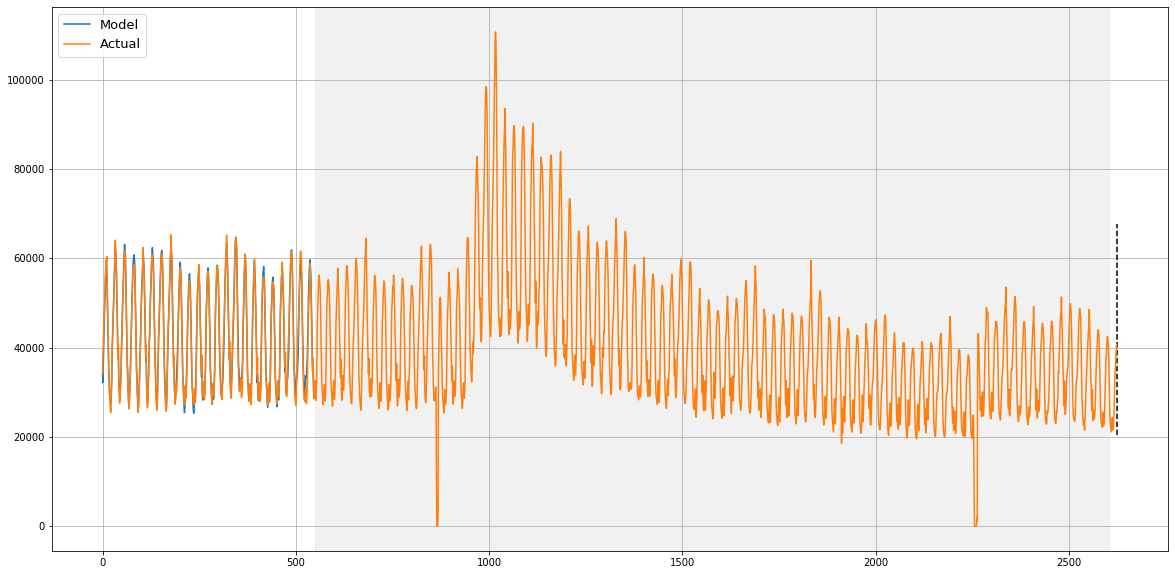

In [65]:
plotHoltWinters(dataset.Users)

In [100]:
dataset.reset_index(inplace=True)
full_idx = pd.date_range(start=dataset.Time.min(), end=dataset.Time.max(), freq='H')
dataset.index=full_idx[:-1]
dataset=dataset.Users

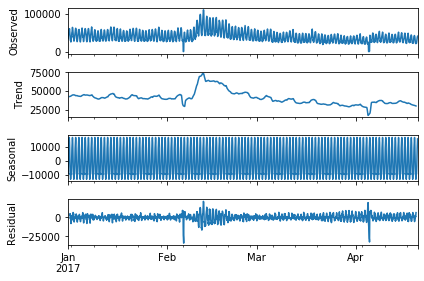

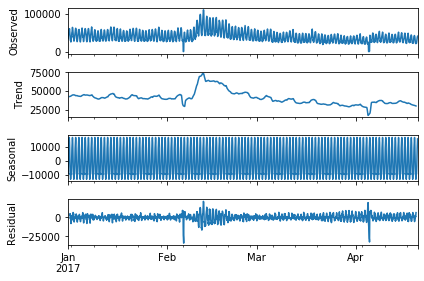

In [104]:
sm.tsa.seasonal_decompose(dataset).plot()

In [105]:
sdd=sm.tsa.seasonal_decompose(dataset)

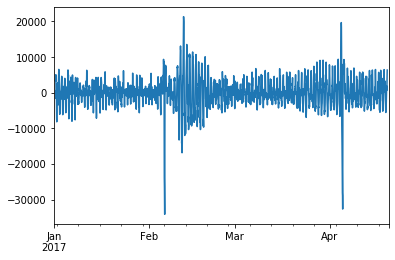

In [115]:
sdd.resid.plot()

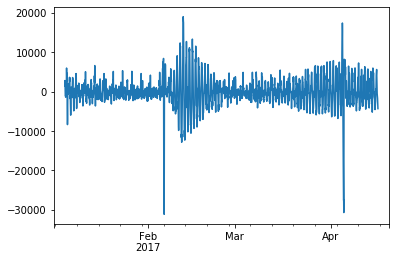

In [124]:
sm.tsa.seasonal_decompose(sdd.resid.dropna(),freq=24*7).resid.plot()

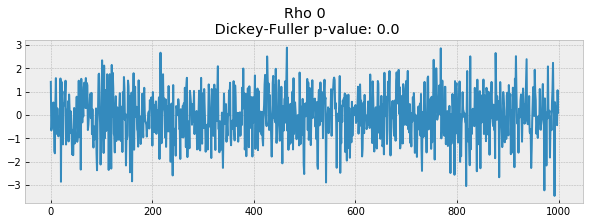

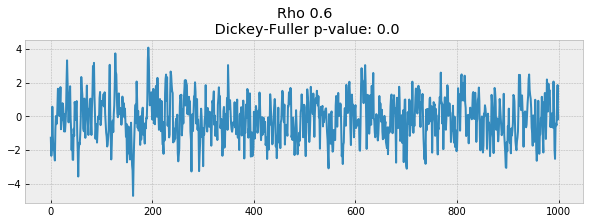

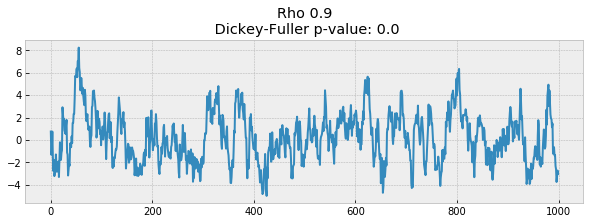

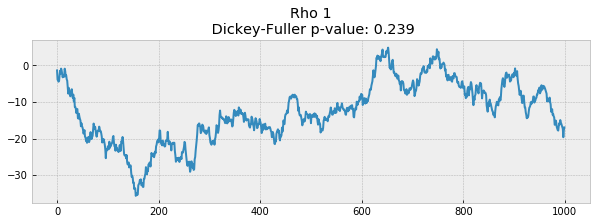

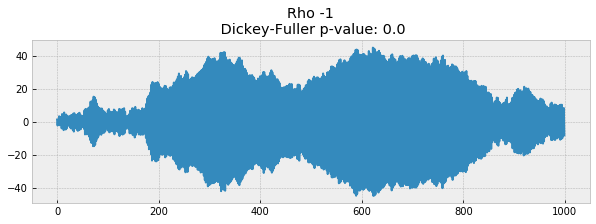

In [128]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1, -1]:
    plotProcess(rho=rho)

In [126]:
x = w = np.random.normal(size=1)
print(x)
print(w)

[-0.27590709]
[-0.27590709]


In [157]:
temp=pd.read_csv(r'C:\Users\eldiy\Downloads/Temp.csv',skiprows=1, sep=';',decimal=b',')

In [158]:
temp.head()

,YearNum,MonthCode,MoyenneDeRR,MoyenneDeTM
0,2010,1,50.460268,1.182103
1,2010,2,71.349446,3.696619
2,2010,3,55.103235,6.820855
3,2010,4,22.837806,10.801815
4,2010,5,65.447538,12.334801


In [159]:
temp['period']=temp.index+1

In [160]:
temp.drop(['YearNum'],axis=1,inplace=True)

In [172]:
X=pd.get_dummies(data=temp, columns=['MonthCode'], drop_first=True).drop(['period','MonthCode_2','MoyenneDeRR','MoyenneDeTM'],axis=1)

In [170]:
import sys
import warnings
warnings.filterwarnings('ignore')

In [173]:
sm.OLS(temp.MoyenneDeTM, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MoyenneDeTM   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     161.6
Date:                Wed, 04 Dec 2019   Prob (F-statistic):           3.52e-60
Time:                        13:24:08   Log-Likelihood:                -210.79
No. Observations:                 119   AIC:                             443.6
Df Residuals:                     108   BIC:                             474.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.3635      0.334     13.069      0.000       3.702       5.025
MonthCode_3      3.4447      0.578      5.957      0.000       2.298       4.591
MonthCode_4      6.3915      0.578     11.052      0.000       5.245       7.538
MonthCode_5      9.2263      0.578     15.954      0.000       8.080      10.373
MonthCode_6     13.3178      0.578     23.030      0.000      12.172      14.464
MonthCode_7     15.5181      0.578     26.835      0.000      14.372      16.664
MonthCode_8     15.1374      0.578     26.176      0.000      13.991      16.284
MonthCode_9     11.9985      0.578     20.748      0.000      10.852      13.145
MonthCode_10     8.5558      0.578     14.795      0.000       7.409       9.702
MonthCode_11     3.8970      0.578      6.739      0.000       2.751       5.043
MonthCode_12     1.1389      0.599      1.900      0.060      -0.049       2.327
==============================================================================
Omnibus:                        0.966   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.617   Jarque-Bera (JB):                1.046
Skew:                          -0.203   Prob(JB):                        0.593
Kurtosis:                       2.787   Cond. No.                         9.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

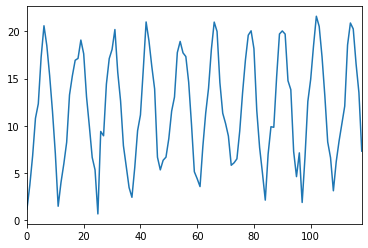

In [152]:
temp.MoyenneDeTM.plot()

In [151]:
round(sm.tsa.stattools.adfuller(temp.MoyenneDeTM)[1], 3)

0.189

In [10]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey Fuller: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return 

Dickey Fuller: p=0.190189


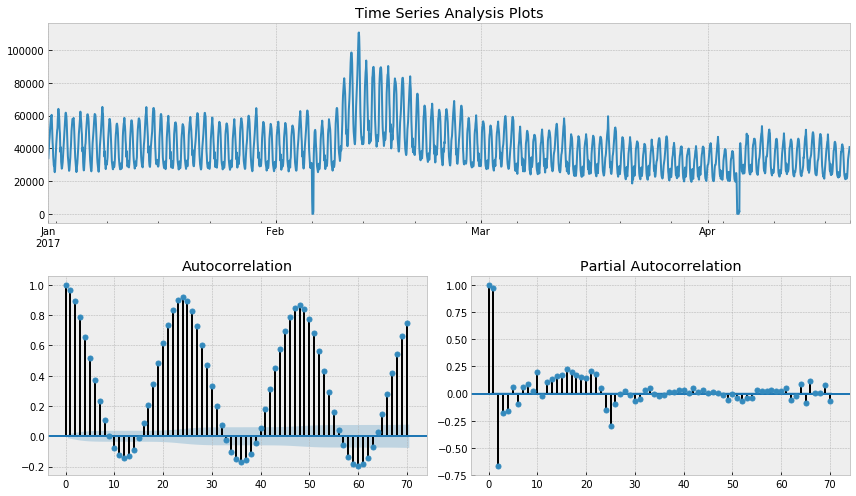

In [180]:
tsplot(dataset, lags=70)

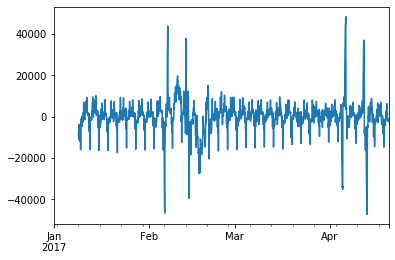

In [189]:
data=dataset.copy()
data=pd.DataFrame(data)
data['Users_season']=data.Users-data.Users.shift(24*7)
#data.Users_season.plot()
data['Users_season_day']=data.Users_season-data.Users_season.shift(24)
data.Users_season_day.plot()


Dickey Fuller: p=0.000000


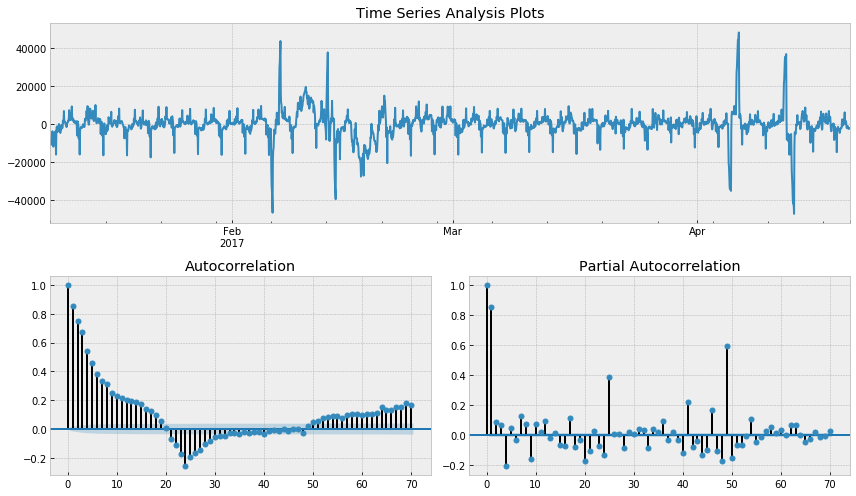

In [191]:
tsplot(data.Users_season_day[24*7+24:], lags=70)

Dickey Fuller: p=0.000000


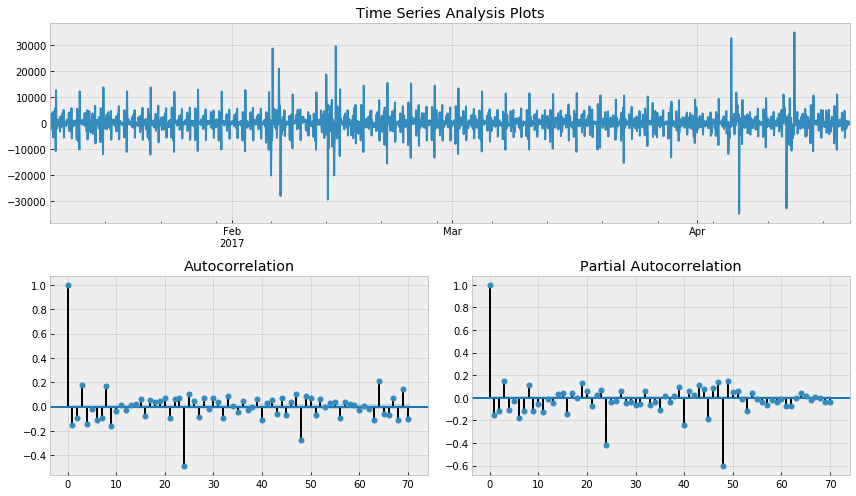

In [196]:
data['last_shift']=data.Users_season_day-data.Users_season_day.shift(1)
tsplot(data.last_shift[24*8+1:],lags=70)

In [4]:
ps=range(2,5)
qs=range(0,3)
d=1

Ps=range(0,5)
Qs=range(0,1)
D=1

In [5]:
from itertools import product
parameters=product(ps,qs,Ps,Qs)
parameters_list=list(parameters)
len(parameters_list)

45

In [7]:
results=[]
best_aic=float('inf')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(dataset.Users, order=(param[0],d,param[1]),
                                       seasonal_order=(param[2],D,param[3],24)).fit()
    except ValueError:
        print('wrong parameters:',param)
        continue
    aic=model.aic
    if aic<best_aic:
        best_model=model
        best_aic=aic
        best_param=param
    results.append([param,model.aic])
    
result_table=pd.DataFrame(results,columns=['parameters','aic'])
result_table.sort_values(by='aic',ascending=True).head()

C:\Users\eldiy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\eldiy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\eldiy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\eldiy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\eldiy\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date inde

In [9]:
param

(2, 1, 3, 0)

In [8]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Users   No. Observations:                 2625
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 24)   Log Likelihood              -23577.321
Date:                            Wed, 04 Dec 2019   AIC                          47166.642
Time:                                    16:51:02   BIC                          47201.822
Sample:                                         0   HQIC                         47179.389
                                           - 2625                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1211      0.012     90.014      0.000       1.097       1.146
ar.L2         -0.2267      0.012    -18.308      0.000      -0.251      -0.202
ma.L1         -0.9719      0.005   -178.636      0.000      -0.983      -0.961
ar.S.L24      -0.6001      0.007    -90.624      0.000      -0.613      -0.587
ar.S.L48      -0.5315      0.005   -102.671      0.000      -0.542      -0.521
sigma2          4e+06   3.66e+04    109.153      0.000    3.93e+06    4.07e+06
===================================================================================
Ljung-Box (Q):                      271.41   Jarque-Bera (JB):            121991.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.98
Prob(H) (two-sided):                  0.97   Kurtosis:                        36.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.78e+14. Standard errors may be unstable.
"""

In [16]:
best_model.resid.apply(abs).mean()

1366.0681765569948

Dickey Fuller: p=0.000000


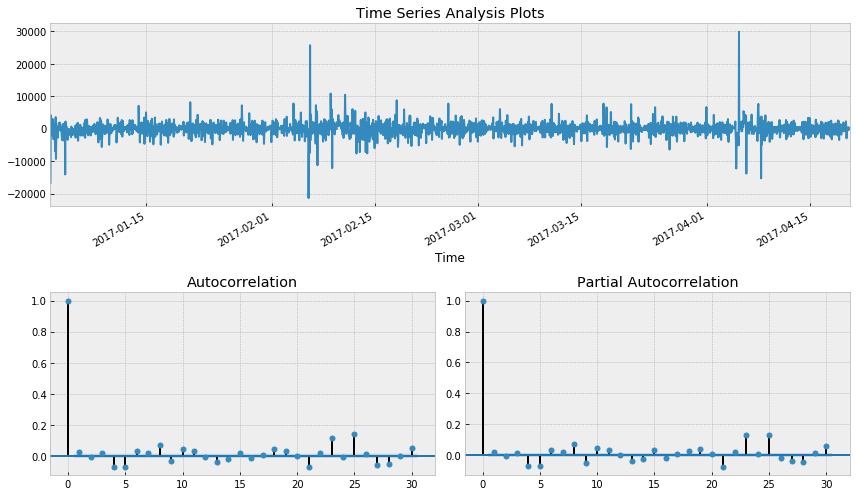

In [11]:
tsplot(best_model.resid[24:],lags=30)

In [12]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    test_index = int(len(data)*(1-test_size))
    
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):
    
    X_train, X_test, y_train, y_test = prepareData(dataset.Users, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000
    
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
    
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]
    
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)
    
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

C:\Users\eldiy\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning:


The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.

C:\Users\eldiy\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning:


The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.



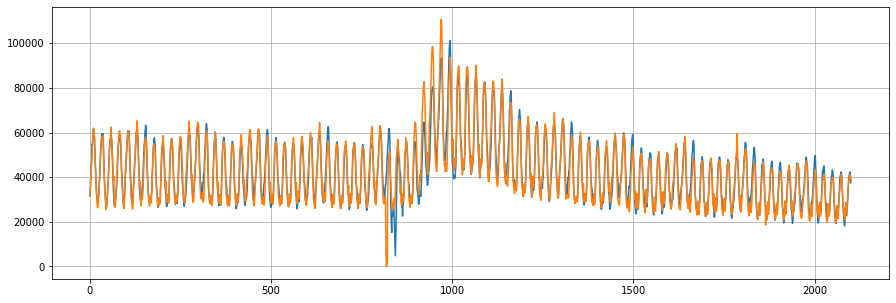

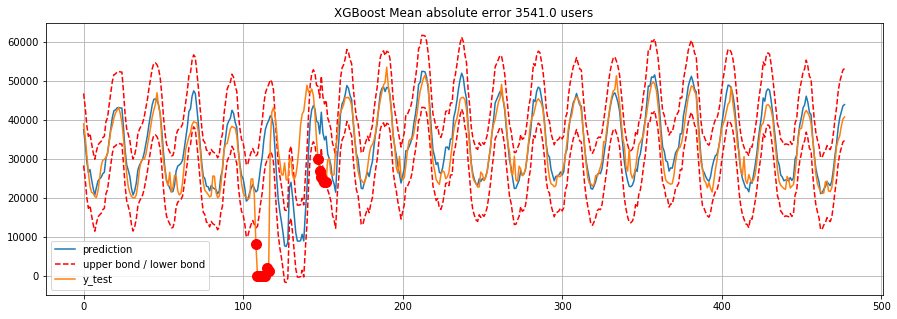

In [17]:
XGB_forecast(pd.DataFrame(dataset), test_size=0.2, lag_start=12, lag_end=48)